In [1]:
#Import statements

import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import GridSearchCV

## Loading the CIFAR10 Dataset

In [ ]:
#Data uploaded on drive and mounted on Google collab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

# Function to load a single CIFAR-10 batch file
def load_cifar10_batch(filename):
    label_byte = 1
    image_bytes = 3 * 1024  # 3 channels * 32 * 32
    single_record = label_byte + image_bytes

    with open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)

    data = data.reshape(-1, single_record)
    labels = data[:, :label_byte].flatten()
    images = data[:, label_byte:].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Converting to HWC format

    return images, labels

# Function to load all CIFAR-10 batches
def load_all_cifar10_batches():
    all_images = []
    all_labels = []

#The data is in batches and in binary files uploaded on drive
    batch_paths = [
        '/content/drive/My Drive/CIFAR10/cifar-10-batches-bin/data_batch_1.bin',
        '/content/drive/My Drive/CIFAR10/cifar-10-batches-bin/data_batch_2.bin',
        '/content/drive/My Drive/CIFAR10/cifar-10-batches-bin/data_batch_3.bin',
        '/content/drive/My Drive/CIFAR10/cifar-10-batches-bin/data_batch_4.bin',
        '/content/drive/My Drive/CIFAR10/cifar-10-batches-bin/data_batch_5.bin'
    ]

    for batch_path in batch_paths:
        images, labels = load_cifar10_batch(batch_path)
        all_images.append(images)
        all_labels.append(labels)

    all_images = np.concatenate(all_images, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_images, all_labels

# Loading all batches
all_images, all_labels = load_all_cifar10_batches()

# Loading the test batch
test_images, test_labels = load_cifar10_batch('/content/drive/My Drive/CIFAR10/cifar-10-batches-bin/test_batch.bin')

# Splitting all_images and all_labels into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)



## Data Visualization

In [4]:
# Displaying the shape of the training, validation and test datasets to confirm the Split

print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Val data shape:", x_val.shape)
print("Val labels shape:", y_val.shape)
print("Test data shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)


Training data shape: (40000, 32, 32, 3)
Training labels shape: (40000,)
Val data shape: (10000, 32, 32, 3)
Val labels shape: (10000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


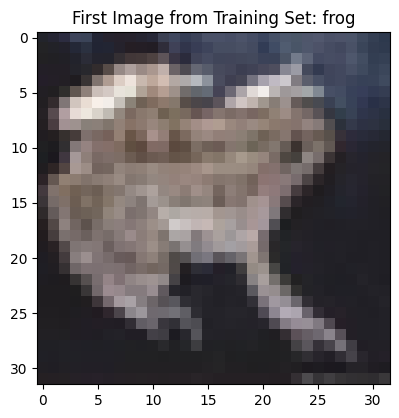

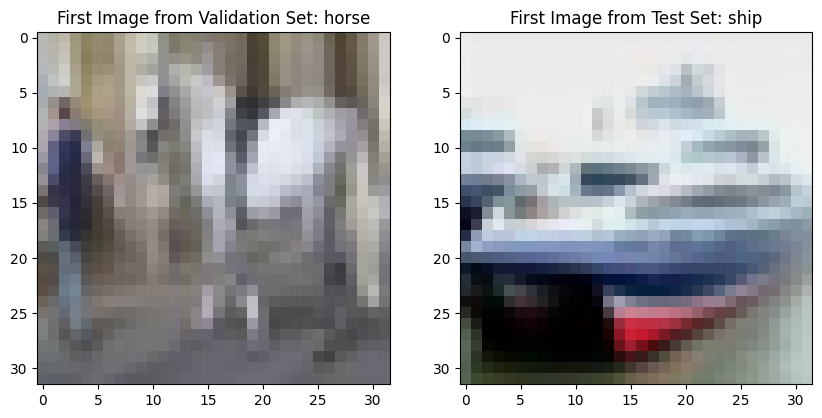

In [5]:
#Checking whether the images are read with appropriate labels

# CIFAR-10 class labels
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Display an image from the training set
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title(f"First Image from Training Set: {cifar10_labels[y_train[0]]}")
plt.imshow(x_train[0])

# Display an image from the validation set
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title(f"First Image from Validation Set: {cifar10_labels[y_val[0]]}")
plt.imshow(x_val[0])

# Displaying an image from the test set
plt.subplot(1, 2, 2)
plt.title(f"First Image from Test Set: {cifar10_labels[test_labels[1]]}")
plt.imshow(test_images[1])

plt.show()


### Verifying whether the data is balanced

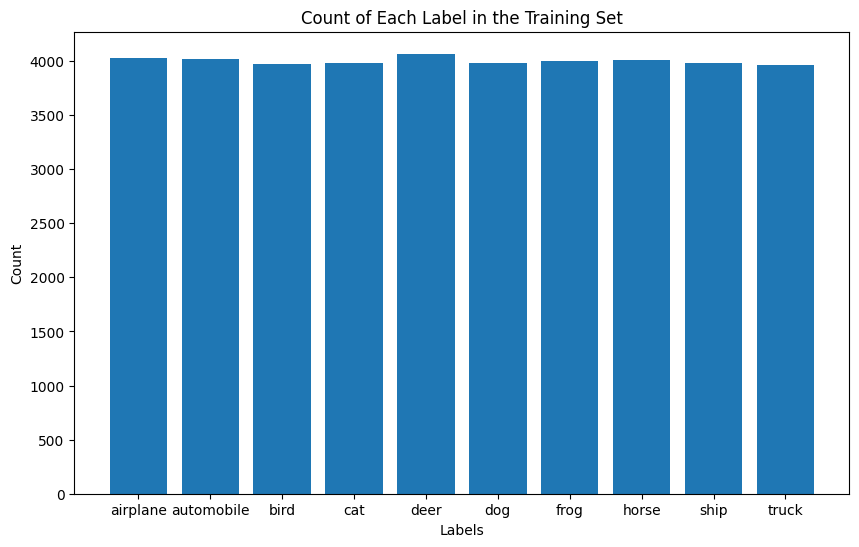

In [6]:

unique_labels, counts = np.unique(y_train, return_counts=True)


cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, tick_label=[cifar10_labels[i] for i in unique_labels])
plt.title('Count of Each Label in the Training Set')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()


## Implementing the Baseline model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#Function to create the baseline structure

def build_baseline_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    # Second convolutional layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Third convolutional layer
    model.add(Conv2D(128, (3, 3), activation='relu'))

    # Flattening the 3D output to 1D tensor for a fully connected layer
    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(128, activation='relu'))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Creating the baseline model
baseline_model = build_baseline_cnn_model()

# Compiling the model
baseline_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Model summary to view the architecture
baseline_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0

## Data Pre-Processing for Models

In [8]:
# Scaling and Normalizing the image data
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


## Training the Baseline model

In [9]:
# Train the model
history = baseline_model.fit(x_train, y_train,
                             epochs=10,
                             batch_size=32,
                             validation_data=(x_val, y_val))


Epoch 1/10
1250/1250 [==============================] - 76s 59ms/step - loss: 1.5431 - accuracy: 0.4377 - val_loss: 1.2501 - val_accuracy: 0.5484
Epoch 2/10
1250/1250 [==============================] - 70s 56ms/step - loss: 1.1615 - accuracy: 0.5862 - val_loss: 1.0841 - val_accuracy: 0.6186
Epoch 3/10
1250/1250 [==============================] - 65s 52ms/step - loss: 0.9977 - accuracy: 0.6507 - val_loss: 0.9703 - val_accuracy: 0.6586
Epoch 4/10
1250/1250 [==============================] - 66s 53ms/step - loss: 0.8863 - accuracy: 0.6890 - val_loss: 0.9541 - val_accuracy: 0.6720
Epoch 5/10
1250/1250 [==============================] - 66s 52ms/step - loss: 0.7977 - accuracy: 0.7230 - val_loss: 0.9175 - val_accuracy: 0.6852
Epoch 6/10
1250/1250 [==============================] - 68s 54ms/step - loss: 0.7155 - accuracy: 0.7485 - val_loss: 0.9035 - val_accuracy: 0.6953
Epoch 7/10
1250/1250 [==============================] - 64s 51ms/step - loss: 0.6437 - accuracy: 0.7723 - val_loss: 0.9266 -

## Plotting the Accuracy and Loss curves

In [12]:

def plot_training_curves(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plotting Training and Validation Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


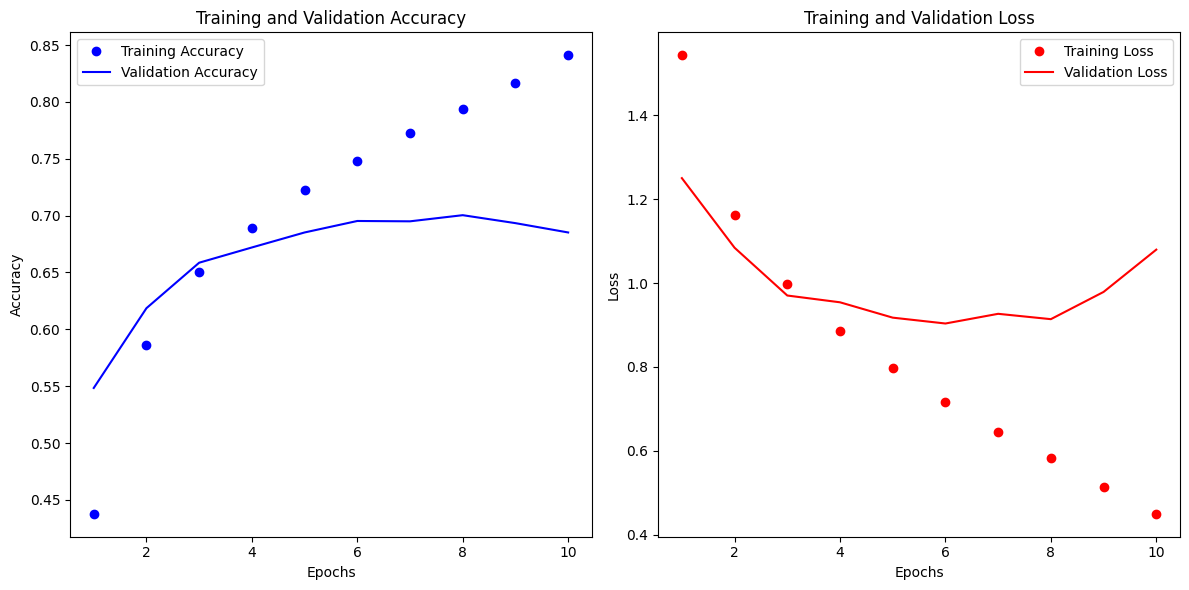

In [13]:
plot_training_curves(history)

In [14]:
# Evaluate the baseline model on the test data

baseline_test_loss, baseline_test_accuracy = baseline_model.evaluate(test_images, test_labels)

# Print the test loss and accuracy for the baseline model
print("Baseline Test Loss:", baseline_test_loss)
print("Baseline Test Accuracy:", baseline_test_accuracy)

313/313 [==============================] - 6s 18ms/step - loss: 1.0838 - accuracy: 0.6792
Baseline Test Loss: 1.0838204622268677
Baseline Test Accuracy: 0.6791999936103821


## Implementing Data Augmentation to avoid Overfitting

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the data generator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# Fit the data generator to the training data
datagen.fit(x_train)

# Train the model using the augmented data
history2 = baseline_model.fit(datagen.flow(x_train, y_train, batch_size=32),
                             epochs=10,
                             validation_data=(x_val, y_val))


Epoch 1/10
1250/1250 [==============================] - 89s 71ms/step - loss: 1.0160 - accuracy: 0.6470 - val_loss: 0.8944 - val_accuracy: 0.6948
Epoch 2/10
1250/1250 [==============================] - 88s 71ms/step - loss: 0.9480 - accuracy: 0.6673 - val_loss: 0.8440 - val_accuracy: 0.7120
Epoch 3/10
1250/1250 [==============================] - 88s 70ms/step - loss: 0.9163 - accuracy: 0.6783 - val_loss: 0.8541 - val_accuracy: 0.7088
Epoch 4/10
1250/1250 [==============================] - 91s 73ms/step - loss: 0.8935 - accuracy: 0.6841 - val_loss: 0.8211 - val_accuracy: 0.7144
Epoch 5/10
1250/1250 [==============================] - 91s 73ms/step - loss: 0.8740 - accuracy: 0.6925 - val_loss: 0.8783 - val_accuracy: 0.7094
Epoch 6/10
1250/1250 [==============================] - 97s 77ms/step - loss: 0.8546 - accuracy: 0.6986 - val_loss: 0.8312 - val_accuracy: 0.7120
Epoch 7/10
1250/1250 [==============================] - 88s 70ms/step - loss: 0.8380 - accuracy: 0.7046 - val_loss: 0.8969 -

## Accuracy vs Loss curves for Data Augmented model

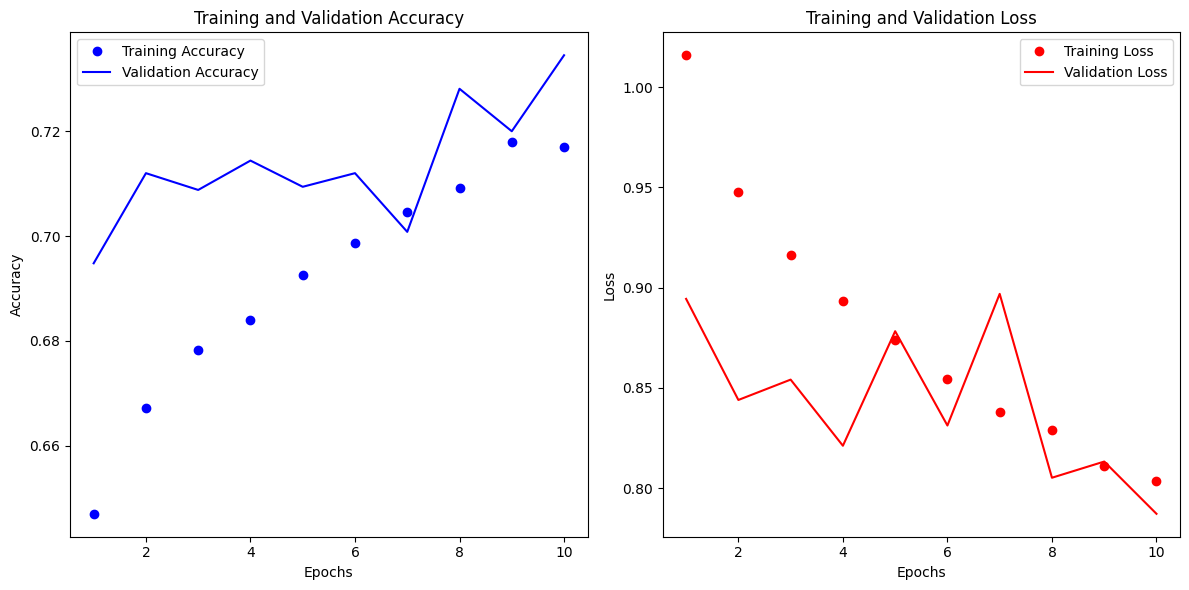

In [16]:
plot_training_curves(history2)

## Implementing Grid search to find best hyperparameters

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define hyperparameter grid
optimizers = ['SGD', 'Adam']
epochs = [10, 20]
batch_sizes = [32, 64]

# Store results
best_accuracy = 0.0
best_params = {}

# Loop over each hyperparameter combination
for optimizer in optimizers:
    for epoch in epochs:
        for batch_size in batch_sizes:
            print(f"Training with optimizer={optimizer}, epochs={epoch}, batch_size={batch_size}")

            # Create and compile model
            model = Sequential([
                Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
                MaxPooling2D((2, 2)),
                Conv2D(64, (3, 3), activation='relu'),
                MaxPooling2D((2, 2)),
                Conv2D(128, (3, 3), activation='relu'),
                MaxPooling2D((2, 2)),
                Flatten(),
                Dense(128, activation='relu'),
                Dense(10, activation='softmax')  # 10 classes for CIFAR-10
            ])
            model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            # Train model
            history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epoch, validation_data=(x_val, y_val))

            # Evaluate model
            loss, accuracy = model.evaluate(x_val, y_val, verbose=0)
            print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

            # Update best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'optimizer': optimizer, 'epochs': epoch, 'batch_size': batch_size}

print("Best parameters found:", best_params)
print("Best accuracy found:", best_accuracy)


Training with optimizer=SGD, epochs=10, batch_size=32
Epoch 1/10
1250/1250 [==============================] - 82s 65ms/step - loss: 2.1573 - accuracy: 0.2001 - val_loss: 1.9525 - val_accuracy: 0.2917
Epoch 2/10
1250/1250 [==============================] - 78s 62ms/step - loss: 1.8971 - accuracy: 0.3084 - val_loss: 1.7542 - val_accuracy: 0.3654
Epoch 3/10
1250/1250 [==============================] - 80s 64ms/step - loss: 1.7258 - accuracy: 0.3761 - val_loss: 1.6030 - val_accuracy: 0.4234
Epoch 4/10
1250/1250 [==============================] - 78s 63ms/step - loss: 1.6188 - accuracy: 0.4139 - val_loss: 1.5170 - val_accuracy: 0.4462
Epoch 5/10
1250/1250 [==============================] - 80s 64ms/step - loss: 1.5495 - accuracy: 0.4415 - val_loss: 1.4733 - val_accuracy: 0.4684
Epoch 6/10
1250/1250 [==============================] - 78s 62ms/step - loss: 1.4925 - accuracy: 0.4658 - val_loss: 1.3804 - val_accuracy: 0.5093
Epoch 7/10
1250/1250 [==============================] - 80s 64ms/step 

## Implementing ResNet50 Model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout

# Creating a ResNet50 model with pre-trained weights from ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


for layer in base_model.layers[-10:]:
    layer.trainable = True

# Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)  # Add dropout with rate of 0.3
predictions = Dense(10, activation='softmax')(x)  # 10 classes for CIFAR-10

# Create the final model
resnet_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Show the model architecture
resnet_model.summary()


94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                         

In [ ]:
# Training the ResNet model
history = resnet_model.fit(x_train, y_train,
                           epochs=10,
                           batch_size=64,
                           validation_data=(x_val, y_val),
                           verbose=1)


Epoch 1/10
625/625 [==============================] - 77s 54ms/step - loss: 1.5186 - accuracy: 0.5150 - val_loss: 2.4346 - val_accuracy: 0.1286
Epoch 2/10
625/625 [==============================] - 33s 52ms/step - loss: 1.0111 - accuracy: 0.6636 - val_loss: 1.2534 - val_accuracy: 0.6072
Epoch 3/10
625/625 [==============================] - 32s 52ms/step - loss: 1.0368 - accuracy: 0.6515 - val_loss: 1.1053 - val_accuracy: 0.6410
Epoch 4/10
625/625 [==============================] - 31s 50ms/step - loss: 0.8141 - accuracy: 0.7260 - val_loss: 0.9992 - val_accuracy: 0.6761
Epoch 5/10
625/625 [==============================] - 32s 51ms/step - loss: 0.7895 - accuracy: 0.7394 - val_loss: 69.7482 - val_accuracy: 0.1970
Epoch 6/10
625/625 [==============================] - 32s 52ms/step - loss: 0.8751 - accuracy: 0.7060 - val_loss: 2.9019 - val_accuracy: 0.3198
Epoch 7/10
625/625 [==============================] - 32s 51ms/step - loss: 0.7753 - accuracy: 0.7465 - val_loss: 1.0198 - val_accuracy

## Adding regularization and dropout layer to Resnet Model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)  # Add a Dropout layer for regularization
predictions = Dense(10, activation='softmax')(x)  # Assuming 10 classes for CIFAR-10

# Create the final model
modified_resnet_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a smaller learning rate
modified_resnet_model.compile(optimizer=Adam(learning_rate=0.0001),
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Summary of the model architecture
modified_resnet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
history = modified_resnet_model.fit(x_train, y_train,
                           epochs=10,
                           batch_size=64,
                           validation_data=(x_val, y_val),
                           verbose=1)

Epoch 1/10
625/625 [==============================] - 62s 53ms/step - loss: 0.6257 - accuracy: 0.9647 - val_loss: 1.3287 - val_accuracy: 0.8066
Epoch 2/10
625/625 [==============================] - 31s 50ms/step - loss: 0.3089 - accuracy: 0.9886 - val_loss: 1.2474 - val_accuracy: 0.8080
Epoch 3/10
625/625 [==============================] - 32s 52ms/step - loss: 0.2157 - accuracy: 0.9898 - val_loss: 1.2494 - val_accuracy: 0.8064
Epoch 4/10
625/625 [==============================] - 31s 50ms/step - loss: 0.1590 - accuracy: 0.9908 - val_loss: 1.1562 - val_accuracy: 0.8061
Epoch 5/10
625/625 [==============================] - 31s 50ms/step - loss: 0.1152 - accuracy: 0.9926 - val_loss: 1.1516 - val_accuracy: 0.8082
Epoch 6/10
625/625 [==============================] - 32s 51ms/step - loss: 0.0861 - accuracy: 0.9939 - val_loss: 1.1650 - val_accuracy: 0.8082
Epoch 7/10
625/625 [==============================] - 33s 52ms/step - loss: 0.0669 - accuracy: 0.9945 - val_loss: 1.2342 - val_accuracy:

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = modified_resnet_model.evaluate(test_images, test_labels, verbose=0)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Test Loss: 1.218268632888794, Test Accuracy: 0.7972999811172485


## References


- The Loading Data set code was referenced from https://www.kaggle.com/datasets/fedesoriano/cifar100
- Baseline model code is taken from previous trimester course Using Machine Learning tools and adapted for this dataset
- ResNet50 Modeling code is referred from https://keras.io/api/applications/